In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 18})
sns.set_style("darkgrid")

# EDA & Data Preprocessing
In this notebook, we're going to carry out a few EDA operations to get acquainted with the data set of the challenge. We will analyze the 7 features and their relationships, generate new derived features and justify the representativeness of a 10% subsample on the basis of faster subsequent training.

## Dataframes creation

In [2]:
df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
df_y = pd.read_csv('../dataset/y_train.csv').drop(columns=['id'])
df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)
df_x.describe()

,trq_measured,oat,mgt,pa,ias,np,ng
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281
std,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084
min,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830
25%,56.100000,7.500000,562.400000,135.331200,51.125000,95.330000,92.226440
50%,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000
75%,75.500000,18.500000,622.300000,588.264000,110.562500,100.020000,99.900000
max,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000


## Explorative Data Analysis
### Skewness study

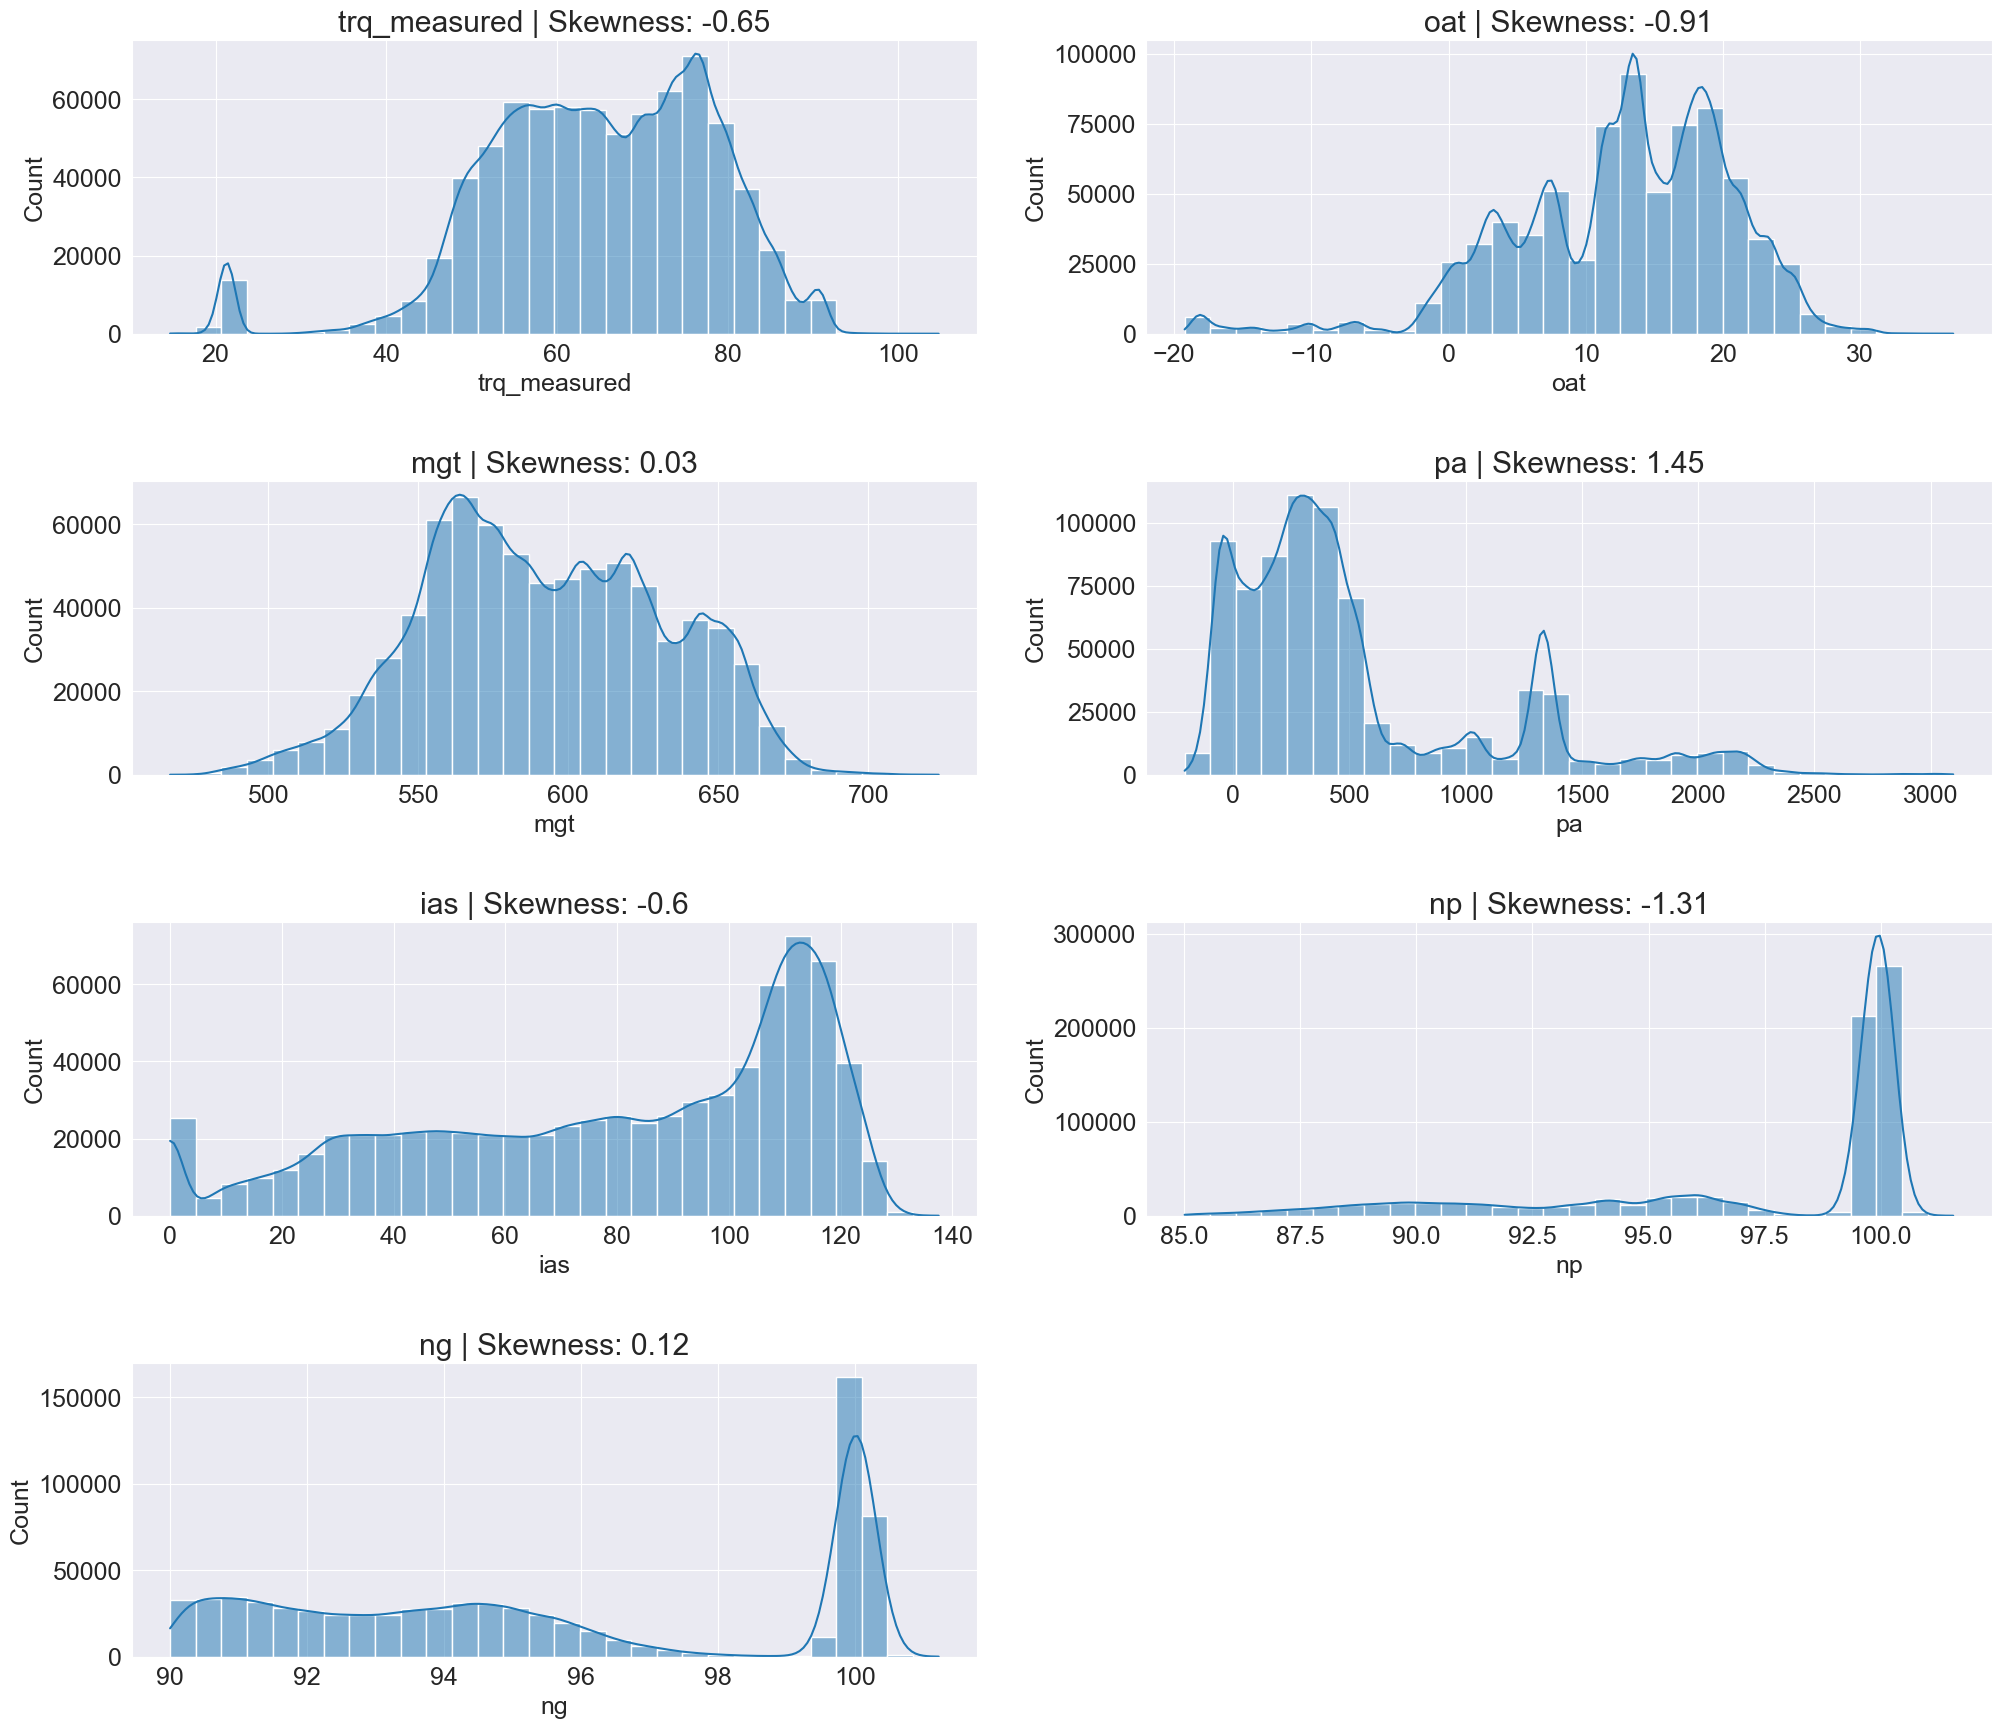

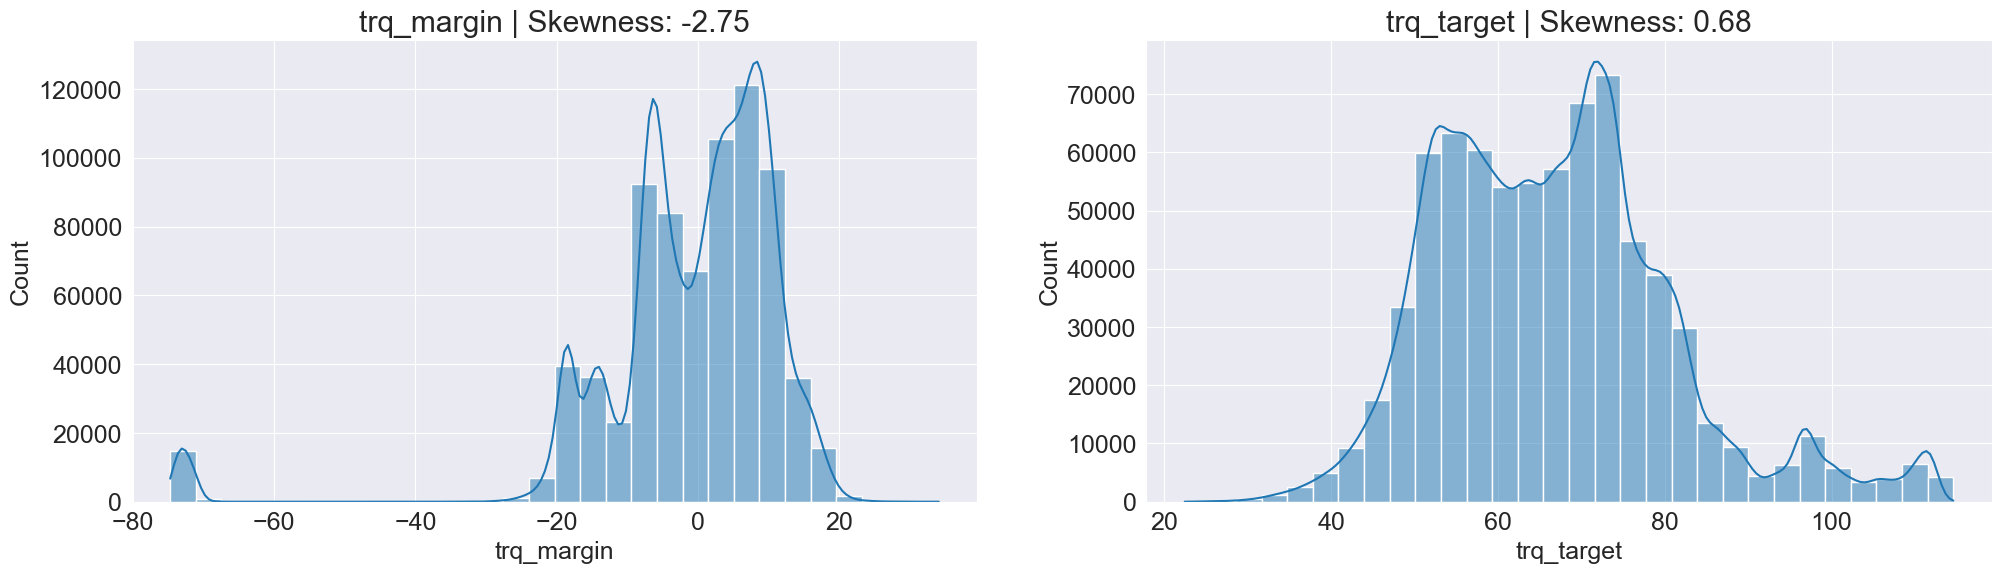

In [14]:
### PLOT FEATURES ###
num_x_features = len(df_x.columns)
plt.figure(figsize=(24, num_x_features * 3))
for idx, feature in enumerate(df_x.columns,1):
    plt.subplot((num_x_features + 1) // 2, 2, idx)
    sns.histplot(df_x[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_x[feature].skew(), 2)}")

plt.subplots_adjust(hspace=0.5)

### PLOT Y_TRAIN FEATURES ###
num_y_features = 2
plt.figure(figsize=(24, num_y_features * 3))
for idx, feature in enumerate(['trq_margin','trq_target'], 1):
    plt.subplot((num_y_features + 1) // 2, 2, idx)
    sns.histplot(df_y[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_y[feature].skew(), 2)}")

# plt.tight_layout()
plt.show()

The features in this dataset that have skewness – exactly 0 depicts the symmetrical distribution and the plots with skewness 1 or above 1 is positively or right skewd distribution. In right skewd or positively skewed distribution if the tail is more on the right side, that indicates extremely high values.

### Faulty distributions

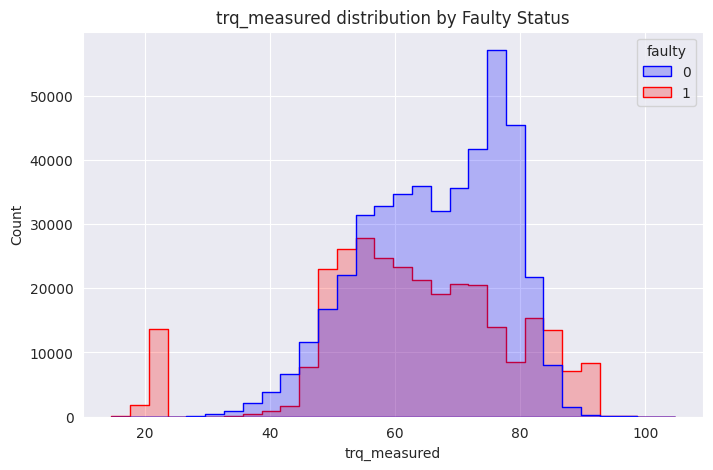

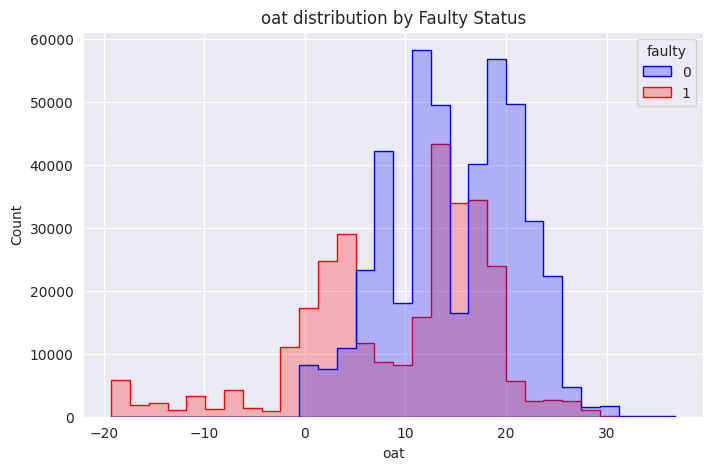

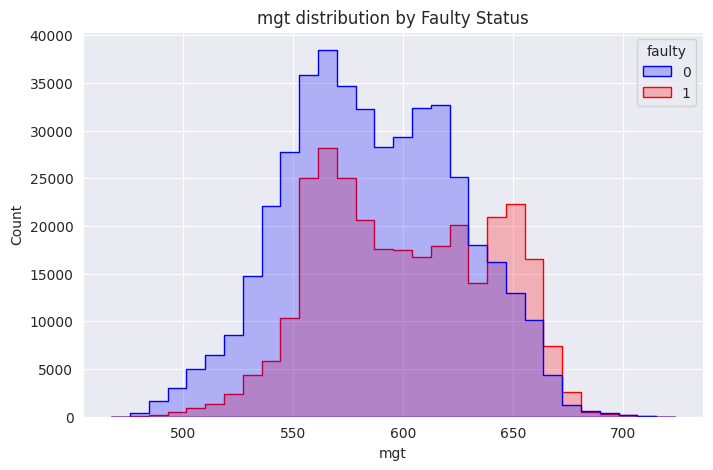

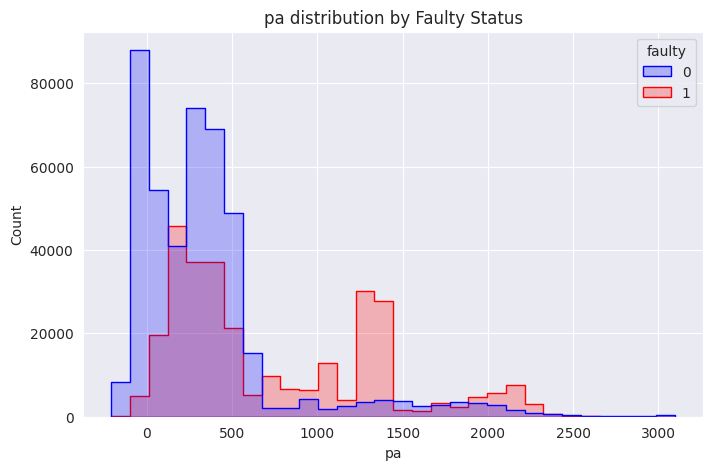

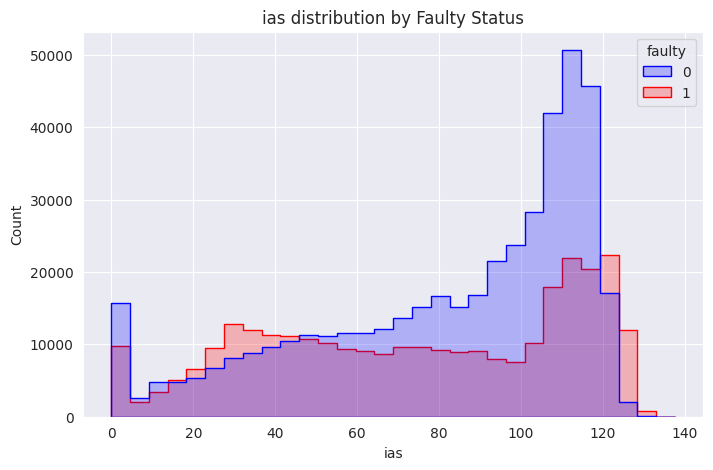

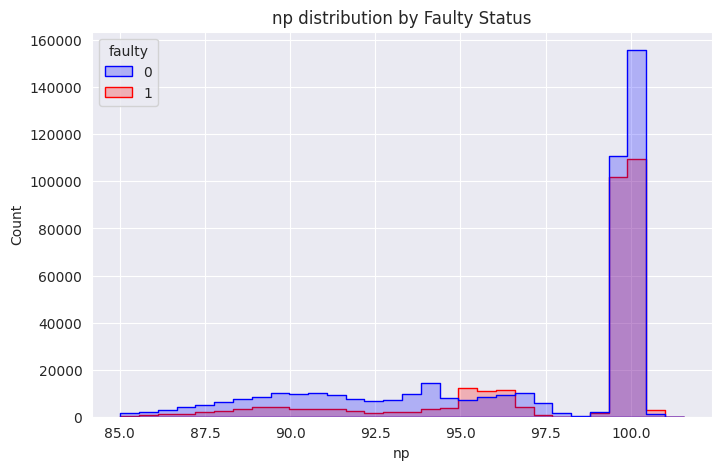

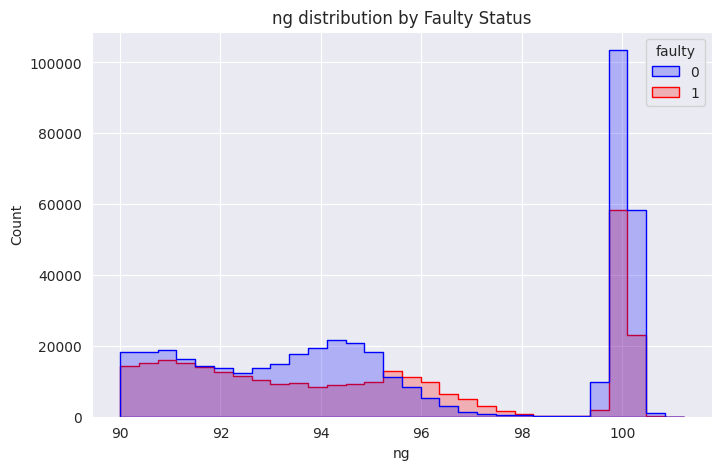

In [16]:
# Check if 'X_train' and 'y_train' exist in the dataframes dictionary
if 'X_train' in dataframes and 'y_train' in dataframes:
    X_train = dataframes['X_train'].drop(columns=["id"], errors="ignore")
    y_train = dataframes['y_train']
    if isinstance(y_train, pd.DataFrame) and "faulty" in y_train.columns:
        y_train = y_train["faulty"]

    # Merge X_train and y_train for easier filtering
    data = X_train.copy()
    data['faulty'] = y_train

    # Select only numerical features
    numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
    num_features = len(numerical_features)

    # Plot histograms for each feature, split by 'faulty' class
    for feature in numerical_features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=data, x=feature, hue='faulty', bins=30, element='step',
                     palette={0: "blue", 1: "red"}, common_norm=False, kde=False)
        plt.title(f"{feature} distribution by Faulty Status")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()

else:
    print("Error: 'X_train' or 'y_train' DataFrame not found in the dataframes dictionary.")


### Feature eptagram

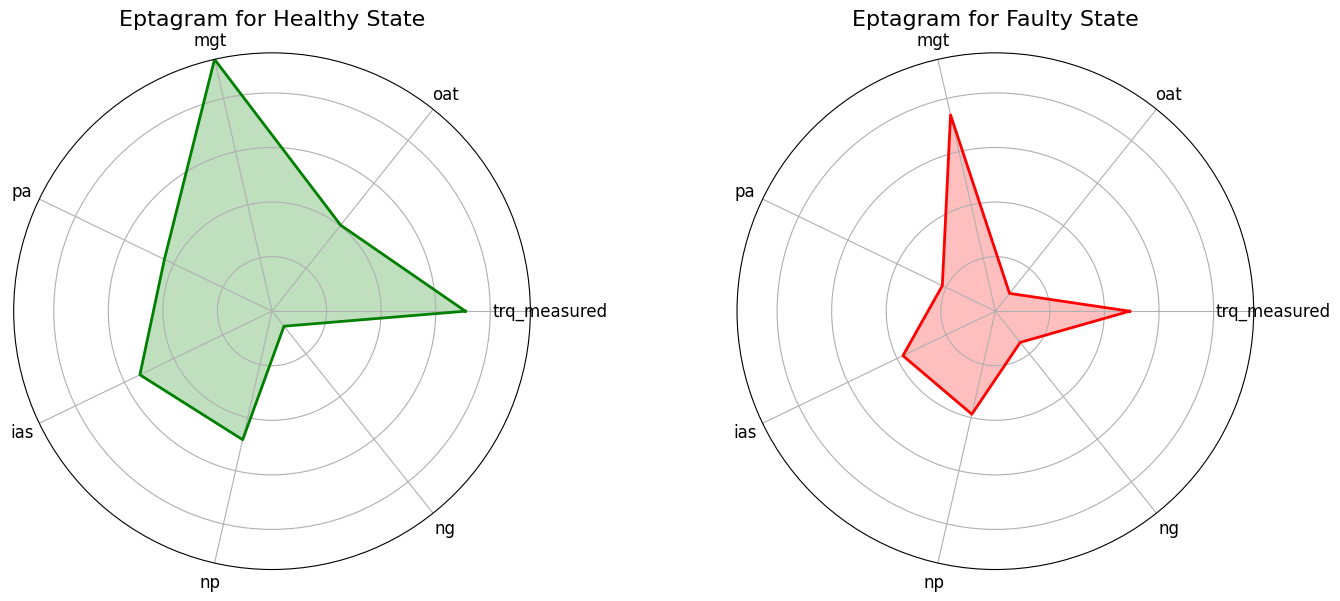

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Load your X_train and y_train DataFrame (with 'id' column already present)
# ----------------------------------------------------------------------

X_train = dataframes['X_train']
y_train = dataframes['y_train']

# Merge the dataframes on the 'id' column
train_data = pd.merge(X_train, y_train, on='id')

# Remove 'id' and 'trq_margin' columns from train_data
train_data = train_data.drop(['id', 'trq_margin'], axis=1)

# Verify the result after removing columns
#print(train_data.columns)

# ----------------------------------------------------------------------
# 2. Split the data into healthy (faulty == 0) and faulty (faulty == 1)
# ----------------------------------------------------------------------
X_train_healthy = train_data[train_data['faulty'] == 0].drop('faulty', axis=1)
X_train_faulty = train_data[train_data['faulty'] == 1].drop('faulty', axis=1)

# ----------------------------------------------------------------------
# 3. Compute correlation matrices for both healthy and faulty datasets
# ----------------------------------------------------------------------
correlation_matrix_healthy = X_train_healthy.corr()
correlation_matrix_faulty = X_train_faulty.corr()

# ----------------------------------------------------------------------
# 4. Prepare data for the radar charts (eptagrams)
#    Compute the average correlation for each feature in both subsets
# ----------------------------------------------------------------------
mean_correlations_healthy = correlation_matrix_healthy.mean(axis=1)
mean_correlations_faulty = correlation_matrix_faulty.mean(axis=1)

labels = mean_correlations_healthy.index
values_healthy = mean_correlations_healthy.values
values_faulty = mean_correlations_faulty.values

# Close the loop for radar charts
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

values_healthy = np.concatenate((values_healthy, [values_healthy[0]]))
values_faulty = np.concatenate((values_faulty, [values_faulty[0]]))

angles += angles[:1]

# ----------------------------------------------------------------------
# 5. Create and display the radar charts (eptagrams) side by side
# ----------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))

# Find the max value to standardize the scaling of both plots
max_value = max(values_healthy.max(), values_faulty.max())

# Radar chart for healthy state
axs[0].fill(angles, values_healthy, color='g', alpha=0.25)
axs[0].plot(angles, values_healthy, color='g', linewidth=2)
axs[0].set_yticklabels([])
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(labels, fontsize=12)
axs[0].set_title("Eptagram for Healthy State", size=16, pad=20)  # Adjust pad for title spacing
axs[0].set_ylim(0, max_value)  # Set same radial scale

# Radar chart for faulty state
axs[1].fill(angles, values_faulty, color='r', alpha=0.25)
axs[1].plot(angles, values_faulty, color='r', linewidth=2)
axs[1].set_yticklabels([])
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(labels, fontsize=12)
axs[1].set_title("Eptagram for Faulty State", size=16, pad=20)  # Adjust pad for title spacing
axs[1].set_ylim(0, max_value)  # Set same radial scale

# Adjust layout to avoid overlap
plt.subplots_adjust(wspace=0.4)

plt.show()


### Correlation study

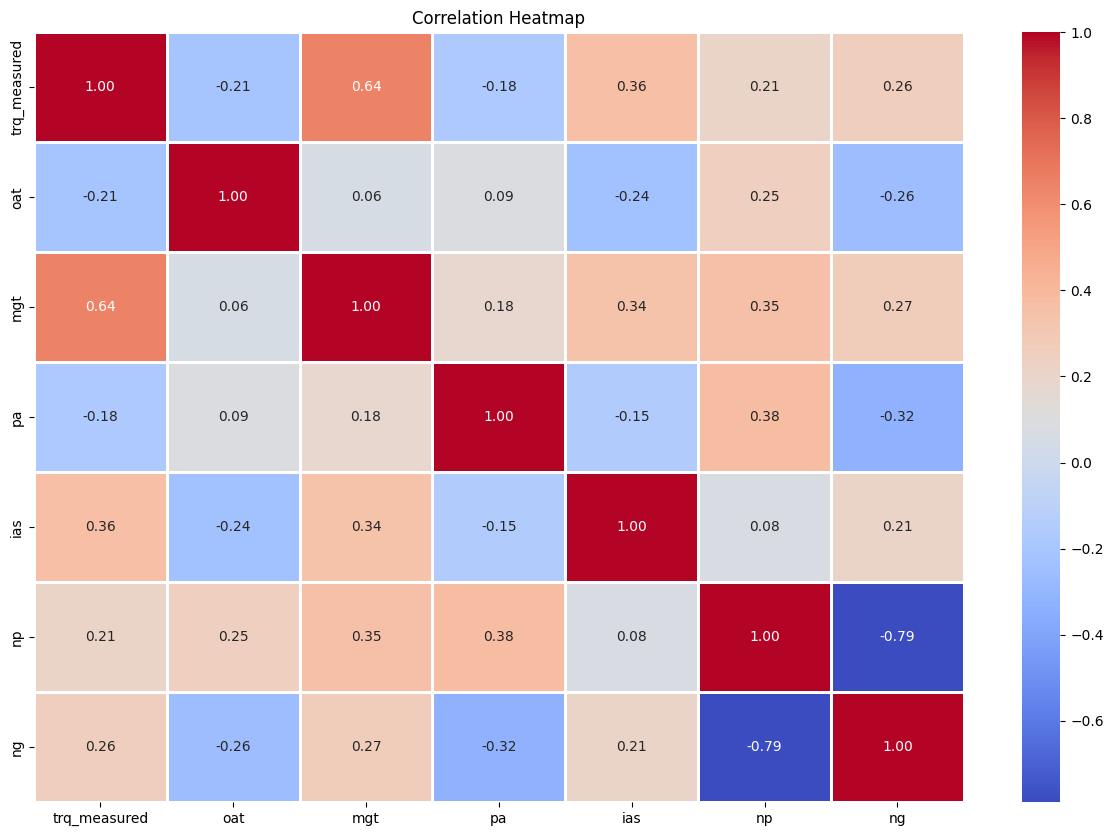

High correlation (0.64) between trq_measured and mgt
High correlation (0.64) between mgt and trq_measured
High correlation (0.79) between np and ng
High correlation (0.79) between ng and np


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea la heatmap con una scala di colori rosso/blu
plt.figure(figsize=(15, 10))

X_train = dataframes['X_train'].drop(columns=["id"], errors="ignore")

sns.heatmap(X_train.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

corr_matrix = X_train.corr().abs()
high_corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.60
]

for col1, col2, corr in high_corr_pairs:
    print(f"High correlation ({corr:.2f}) between {col1} and {col2}")


### PCA

Explained variance by each component: [0.32379099 0.29137514]
Loading for Principal Component 1:
trq_measured: 0.3701
oat: -0.3308
mgt: 0.2293
pa: -0.3429
ias: 0.3398
np: -0.3786
ng: 0.5697

Loading for Principal Component 2:
trq_measured: 0.4634
oat: 0.0651
mgt: 0.5656
pa: 0.2267
ias: 0.2996
np: 0.5376
ng: -0.1758



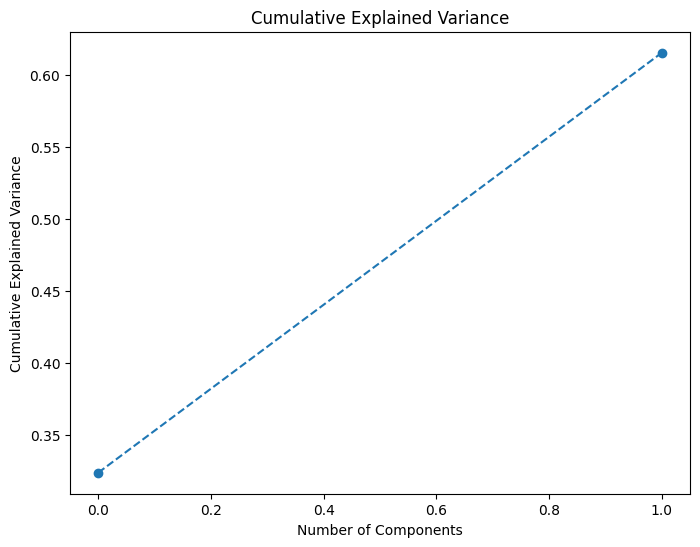

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


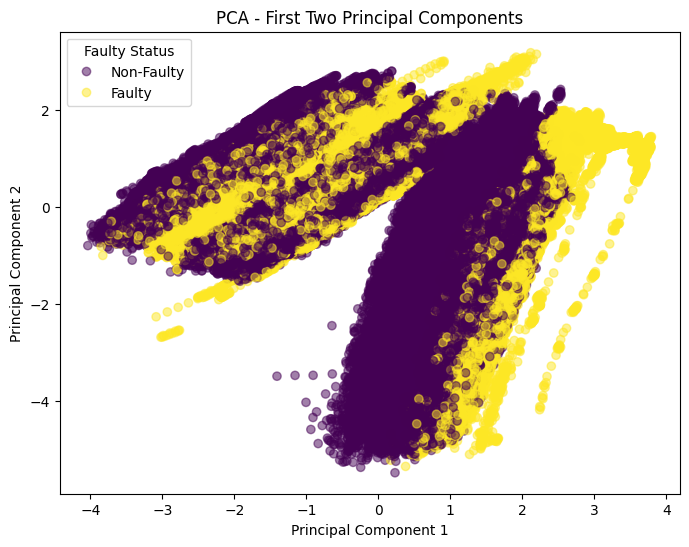

In [ ]:

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Remove 'id' column if it exists (it's not useful for modeling)
X_train = dataframes['X_train'].drop(columns=["id"], errors="ignore")

# 2. Normalize the data (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 3. Apply PCA
pca = PCA(n_components=2)  # Set 2 principal components for visualization
X_pca = pca.fit_transform(X_scaled)

# 4. Display the explained variance by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")

# Print the loadings of each principal component
loadings = pca.components_
for i, loading in enumerate(loadings):
    print(f"Loading for Principal Component {i + 1}:")
    for feature, value in zip(X_train.columns, loading):
        print(f"{feature}: {value:.4f}")
    print()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# 5. Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)

# Add title and labels
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend for 'Faulty' and 'Non-Faulty'
handles, labels = scatter.legend_elements()
plt.legend(handles, ['Non-Faulty', 'Faulty'], title="Faulty Status")

plt.show()


# Dataset sampling: skewness study

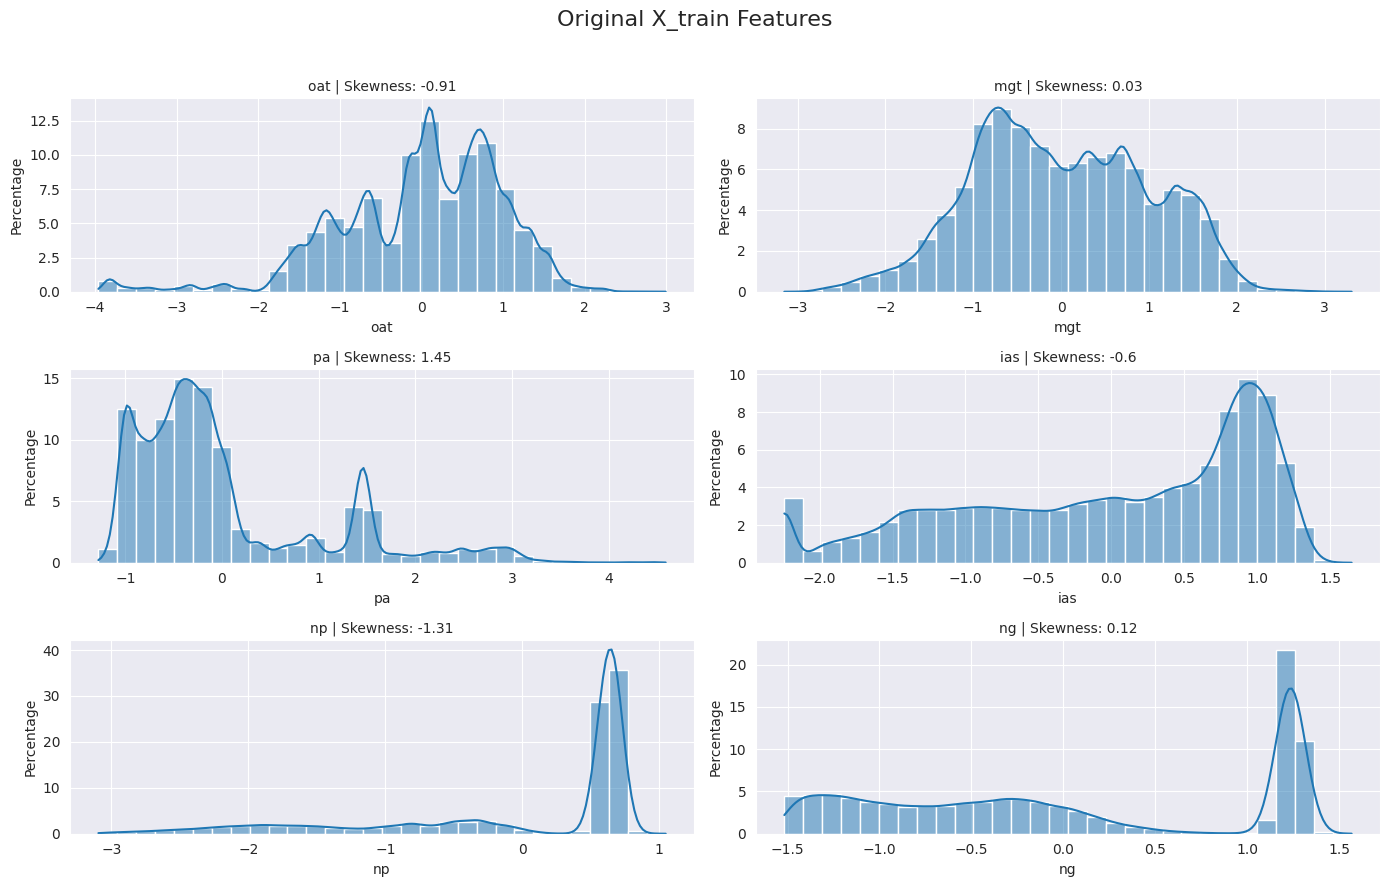

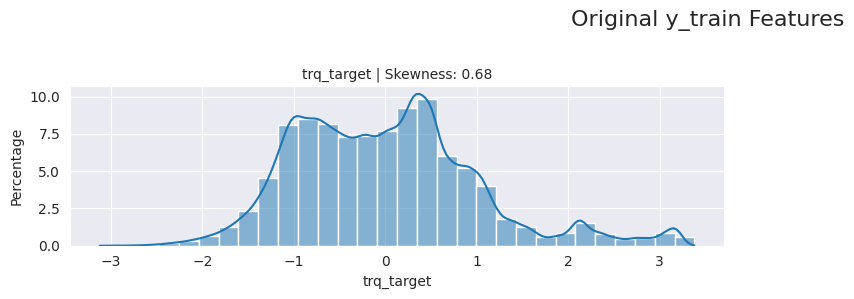

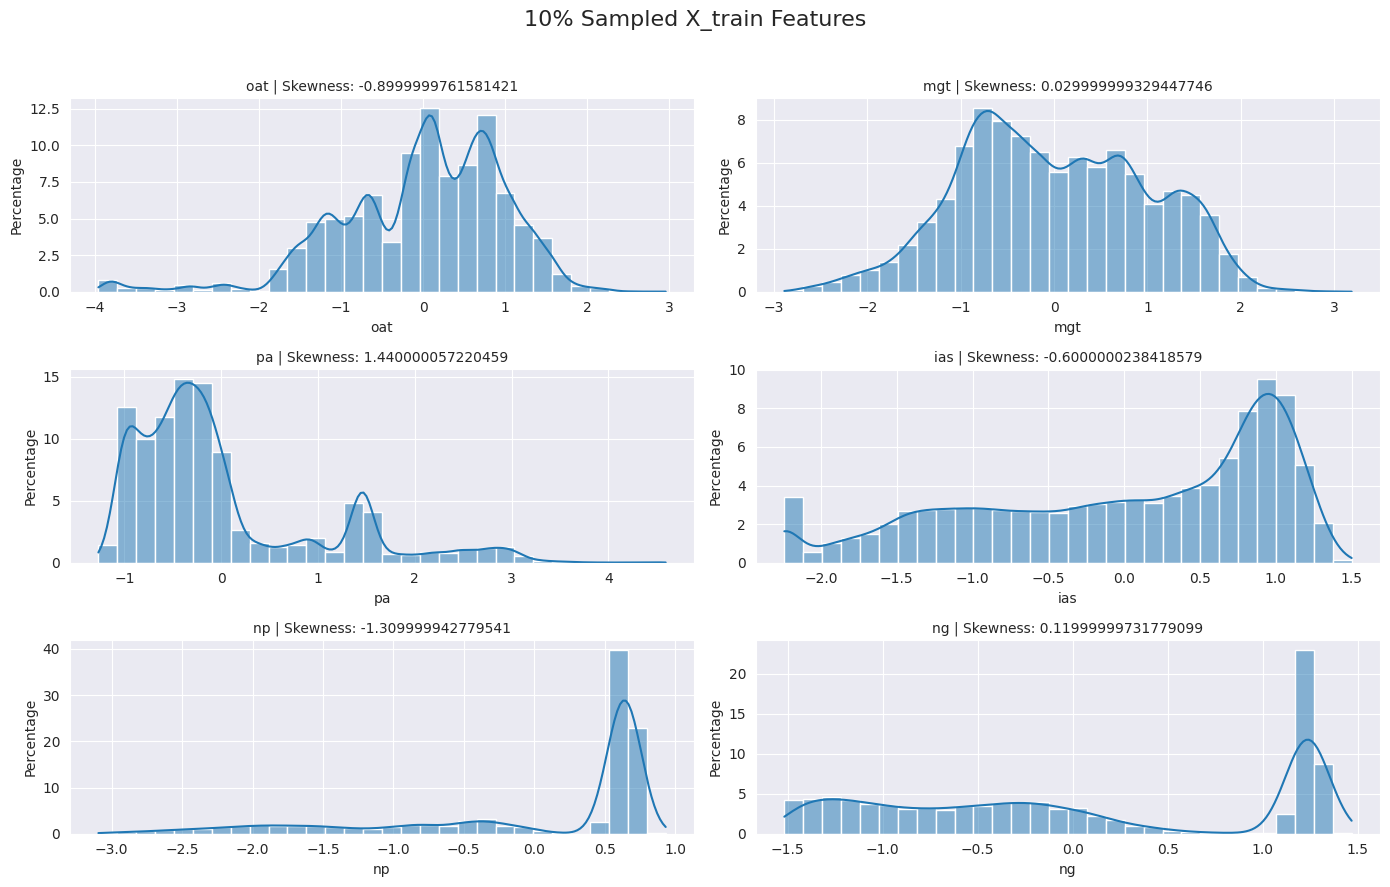

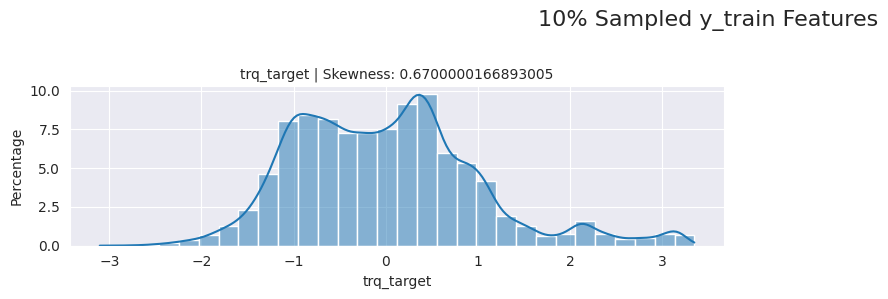

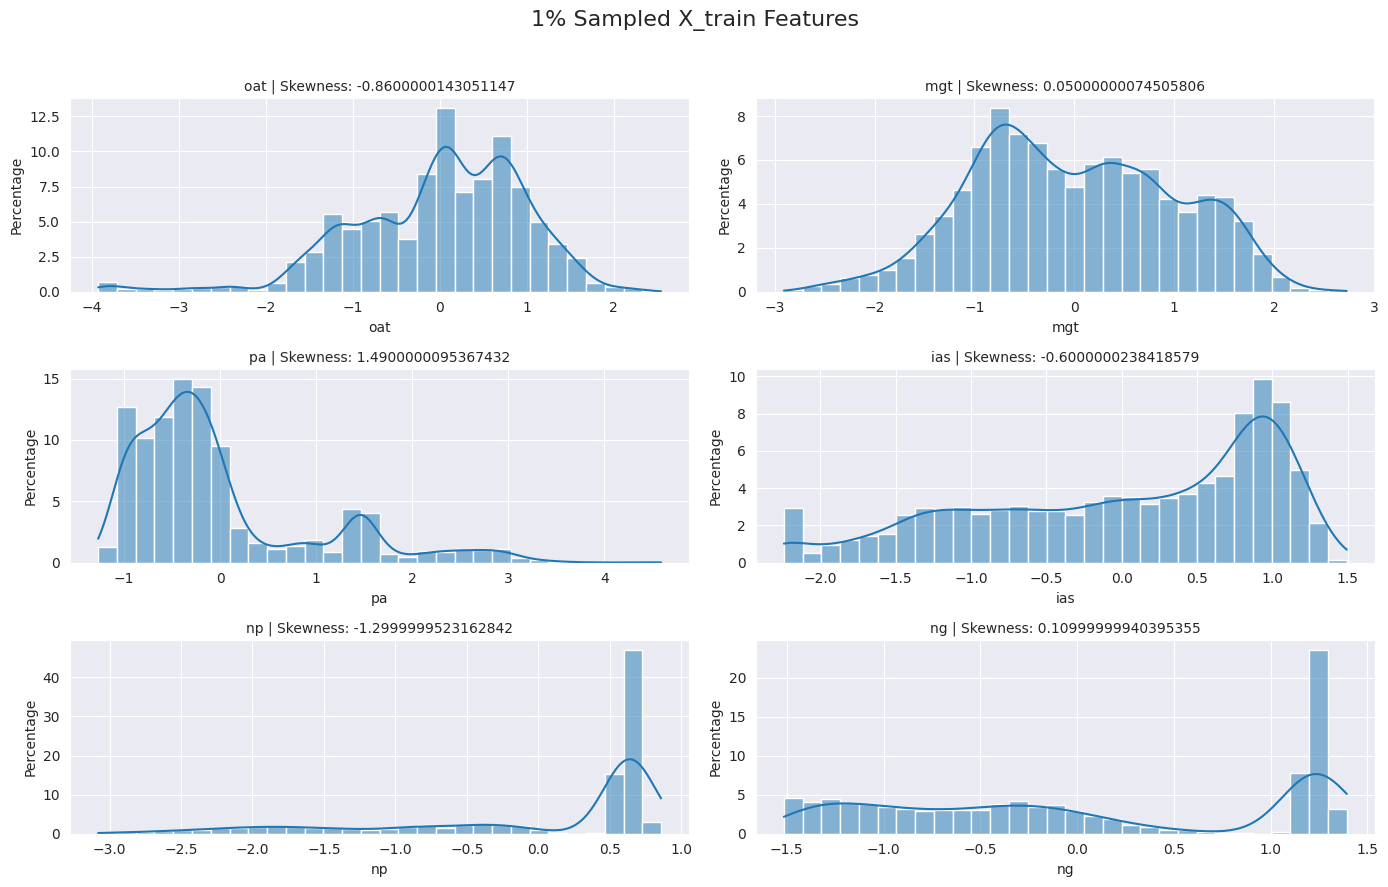

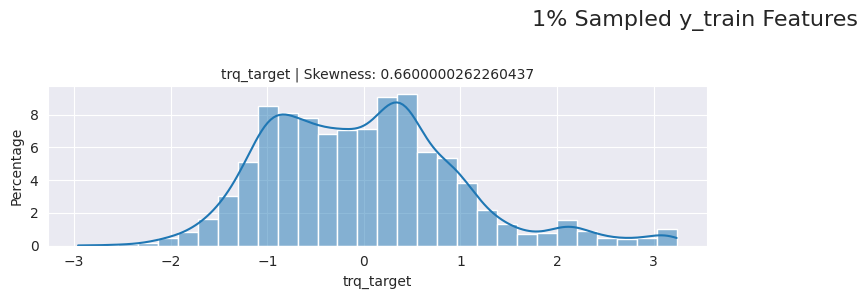

Skewness differences (Original - 10% Sampled):
oat   -0.009403
mgt   -0.003514
pa     0.007693
ias   -0.001658
np     0.000895
ng     0.000166
dtype: float64

Skewness differences (Original - 1% Sampled):
oat   -0.051237
mgt   -0.015099
pa    -0.039167
ias   -0.008142
np    -0.009547
ng     0.006376
dtype: float64


In [3]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd

# Set seaborn style
sns.set_style("darkgrid")

if 'X_train' in dataframes and 'y_train' in dataframes:
    X_train = dataframes['X_train'].drop(columns=["id"], errors="ignore")
    y_train = dataframes['y_train']
    y_train['trq_target'] = X_train['trq_measured'] / (y_train['trq_margin'] / 100 + 1)
    if "faulty" in y_train:
        y_train = y_train.drop(columns=["faulty", "id"], errors="ignore")

    # Normalize data
    X_train_normalized = (X_train - X_train.mean()) / X_train.std()
    y_train_normalized = (y_train['trq_target'] - y_train['trq_target'].mean()) / y_train['trq_target'].std()
    X_train_normalized.drop(columns=['trq_measured'], inplace=True)

    device = "cpu"
    train_x_1 = torch.tensor(X_train_normalized.values, dtype=torch.float32, device=device)
    train_y_1 = torch.tensor(y_train_normalized.values, dtype=torch.float32, device=device).unsqueeze(1)

    assert train_x_1.shape[0] == train_y_1.shape[0]

    # Downsampling
    np.random.seed(42)

    random_indices_10 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 10, replace=False)
    train_x_10 = train_x_1[random_indices_10].numpy()
    train_y_10 = train_y_1[random_indices_10].numpy()

    random_indices_100 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 100, replace=False)
    train_x_100 = train_x_1[random_indices_100].numpy()
    train_y_100 = train_y_1[random_indices_100].numpy()

    # Convert to DataFrame for analysis
    df_x_10 = pd.DataFrame(train_x_10, columns=X_train_normalized.columns)
    df_y_10 = pd.DataFrame(train_y_10, columns=['trq_target'])
    df_x_100 = pd.DataFrame(train_x_100, columns=X_train_normalized.columns)
    df_y_100 = pd.DataFrame(train_y_100, columns=['trq_target'])


    def plot_skewness(df, title):
        num_features = len(df.columns)
        rows = (num_features + 1) // 2
        fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 3))
        fig.suptitle(title, fontsize=16)
        axes = axes.flatten()

        for idx, feature in enumerate(df.columns):
            sns.histplot(df[feature], kde=True, bins=30, ax=axes[idx], stat="percent")
            axes[idx].set_title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}", fontsize=10)
            axes[idx].set_ylabel("Percentage")

        for i in range(idx + 1, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


    # Plot skewness for original and sampled datasets
    plot_skewness(X_train_normalized, "Original X_train Features")
    plot_skewness(y_train_normalized.to_frame(), "Original y_train Features")

    plot_skewness(df_x_10, "10% Sampled X_train Features")
    plot_skewness(df_y_10, "10% Sampled y_train Features")

    plot_skewness(df_x_100, "1% Sampled X_train Features")
    plot_skewness(df_y_100, "1% Sampled y_train Features")

    # Compute skewness differences
    skew_diff_10 = X_train_normalized.skew() - df_x_10.skew()
    skew_diff_100 = X_train_normalized.skew() - df_x_100.skew()

    print("Skewness differences (Original - 10% Sampled):")
    print(skew_diff_10)
    print("\nSkewness differences (Original - 1% Sampled):")
    print(skew_diff_100)
else:
    print("Error: 'X_train' or 'y_train' DataFrame not found in the dataframes dictionary.")


# Feature building

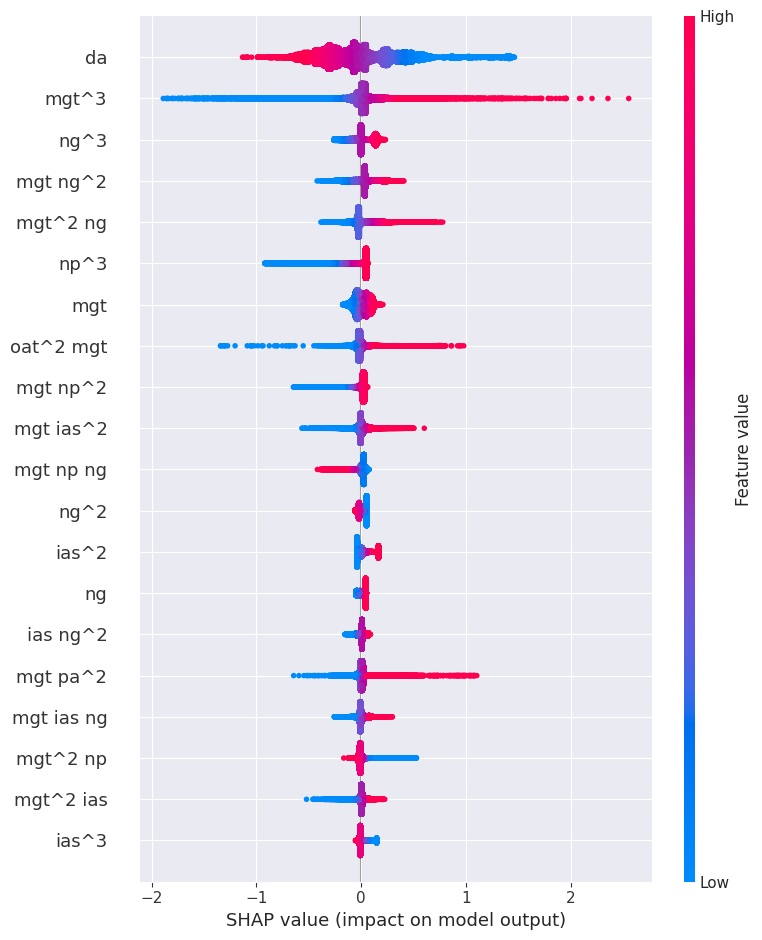

In [5]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import shap
import seaborn as sns
import matplotlib.pyplot as plt

df_x_10 = pd.DataFrame(train_x_10, columns=X_train_normalized.columns)
df_y_10 = pd.DataFrame(train_y_10, columns=['trq_target'])

# 1) Create Features
# Add Polynomial Features (degree=N includes features up to N°)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(df_x_10)

# Create new DataFrame with Polynomial Features
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(df_x_10.columns))

# Add NP/NG ratio feature
df_x_10['np_ng_ratio'] = df_x_10['np'] / df_x_10['ng']

# Air density formula: da = 1.2376 * pa + 118.8 * oat - 1782
df_x_10['da'] = (1.2376 * df_x_10['pa']) + (118.8 * df_x_10['oat']) - 1782

# Combine the original and newly created features into a new DataFrame
df_x_new = pd.concat([df_x_10, poly_df], axis=1)

# Drop duplicate columns (keeping only one instance of each)
df_x_new = df_x_new.loc[:, ~df_x_new.columns.duplicated()]

#print(df_x_new.head())

# 2) Apply SHAP for Regression using trq_target as label
# Fit a regression model (Linear Regression in this case)
model = LinearRegression()
model.fit(df_x_new, df_y_10)

# Initialize SHAP Explainer
explainer = shap.Explainer(model, df_x_new)

# Compute SHAP values
shap_values = explainer(df_x_new)

# Plot SHAP summary with automatic main features selection
shap.summary_plot(shap_values, df_x_new)
# Plot SHAP summary with all features
#shap.summary_plot(shap_values, df_x_new, max_display=df_x_new.shape[1])